In [1]:
%%capture output
# Create a virtual filesystem based on the http protocol and use caching to save accessed data to RAM.
# Open the file with NWBHDF5IO

from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

from pynwb import NWBHDF5IO
from fsspec import filesystem
from h5py import File
from dandi.dandiapi import DandiAPIClient

dandiset_id = "000409"  # the IBL Brain Wide Map dataset
file_path = 'sub-CSHL052/sub-CSHL052_ses-4b00df29-3769-43be-bb40-128b1cba6d35-processed-only_behavior.nwb'

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)
fs = filesystem("http")
file_system = fs.open(s3_url, "rb")
file = File(file_system, mode="r")

hdf5io = NWBHDF5IO(file=file, load_namespaces=True)
nwb = hdf5io.read()

In [2]:
## Loads and display the trials table
df_trials = nwb.trials.to_dataframe()
df_trials.head()

,start_time,stop_time,choice,feedback_type,reward_volume,contrast_left,contrast_right,probability_left,feedback_time,response_time,stim_off_time,stim_on_time,go_cue_time,first_movement_time
id,,,,,,,,,,,,,,
0,14.627100,18.290832,-1.0,1.0,1.5,NaN,1.0000,0.5,16.740700,16.740617,17.790733,16.424200,16.356567,16.5515
1,18.656933,21.924065,-1.0,1.0,1.5,NaN,1.0000,0.5,20.368833,20.368749,21.424033,20.207400,20.208233,20.1415
2,22.327967,26.890800,1.0,-1.0,0.0,NaN,0.0625,0.5,24.329200,24.328280,26.390800,23.790767,23.791567,24.2195
3,27.253800,30.190632,1.0,1.0,1.5,0.125,NaN,0.5,28.635733,28.635614,29.690533,28.257033,28.257867,28.4835
4,30.547633,37.690399,-1.0,-1.0,0.0,0.250,NaN,0.5,35.140833,35.137674,37.190300,35.057133,35.058167,34.9765


<Axes: xlabel='signed_contrast', ylabel='rightward_choices'>

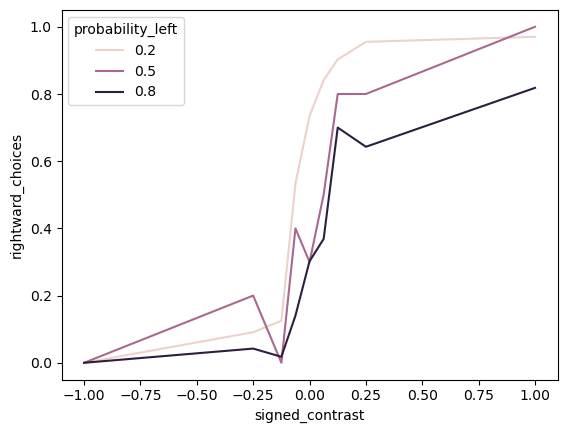

In [3]:
## Compute and display the psychometric curve per biased block
# the signed contrast fields ranges from -100 for left at 100% to 100 for right 100%
df_trials['signed_contrast'] = np.nansum(np.c_[
    df_trials['contrast_left'] * -1,
    df_trials['contrast_right']], axis=1)
# aggregate the trials table per block and signed contrast to plot the psychometric curve
df_psych = df_trials.groupby(['probability_left', 'signed_contrast']).agg(
    rightward_choices=pd.NamedAgg(column='choice', aggfunc=lambda x: np.sum(x == -1) / np.sum(x != 0)),
)
sns.lineplot(data=df_psych, x='signed_contrast', y='rightward_choices', hue='probability_left')